# Calibración del biprisma

En este experimento se pretende obtener todos los datos necesarios para realizar la calibración de un SLM mediante los métodos de Moreno, Baiheng, Amaya, Hoyo y Hoyo extendido. Posteriormente, dichos datos se deberán analizar en un segundo notebook para obtener los valores finales.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from diffractio import degrees, mm, plt, sp, um, np
from diffractio.scalar_masks_XY import Scalar_mask_XY

from py_lab.camera import Camera
from py_lab.motor import Motor
from py_lab.utils import List_COM_Ports
from py_lab.slm import SLM
from py_lab.daca import DACA, Close_All_DACA
from py_lab.setups.slm_calibration import *

import shutil

number of processors: 4
total memory        : 6.0 Gb
available memory    : 59 %
max frequency       : 2794 GHz


## Creación de objetos

En primer lugar, vamos a crear los objetos que servirán para controlar los diferentes equipos del experimento.

In [3]:
# Camara
cam = Camera(name="ImagingSource")
# cam.Open() # Aun no la abrimos para poder usar el programa de la compañia en la primera parte del experimento

In [4]:
# Motores
motor = Motor(name="SMC100")
motor.Open(invert=True) # Al invertir el movimiento, moverse en negativo nos acerca al SLM y en positivo nos aleja.
motor.Home()

Connecting to SMC100 on COM3


SMC100WaitTimedOutException: Wait timed out

In [ ]:
motor.Close()

In [6]:
# SLM
slm = SLM(name="HoloEye2500")

In [7]:
slm.Close_All_Images()

In [8]:
# Data acquisition card
daca = DACA(name="U3")
daca.Open(AIN=[2], AIN_ref=1)

Ir al directorio deseado para guardar los datos

In [9]:
%pwd
%cd H:\Experimentos Jesus\Fase4
%pwd

H:\Experimentos Jesus\Fase4


'H:\\Experimentos Jesus\\Fase4'

## Matriz de Jones

Ahora, vamos a medir la matriz de Jones del SLM. Para eso, va a haber que hacer 1 medida de intensidad como referencia antes del sistema, y después otras 36 medidas después del PSA, con una configuración diferente para cada una. En cada configuración, se tendrá que ir cambiando el nivel de gris de todo el SLM (no tenemos resolucion espacial). Son muchas medidas, pero se puede conseguir!

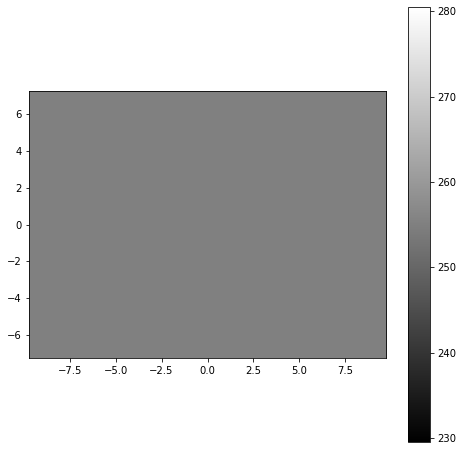

In [8]:
# Comprobacion del patron del SLM
level = np.sqrt(1)
gris_unico = Scalar_mask_XY(x=slm.x, y=slm.y, wavelength=633e-6)
gris_unico.gray_scale(num_levels=1, levelMin=level, levelMax=level) # Solo para probar qeu funciona bien
slm.Send_Image(image=gris_unico, kind='intensity', norm=1, draw=True)

#### Medidas

Ya podemos comenzar con las medidas. Primero, la medida de referencia.

In [10]:
# Medir el background
_ = daca.Get_Signal(is_background=True, verbose=True)

Reference:  0.014271999999998286
Signal:  [0.07456]


In [11]:
# Tomar una medida para comprobar la tarjeta de adquisicion
P0 = daca.Get_Signal(verbose=True)

Signal:  [2.60875161]


Ahora, vamos a hacer las medidas en bucle. El programa muestra los angulos a los que hay que colocar los elementos de polarizacion y, al terminar la medida, muestra una gráfica con las medidas tomadas y sus errores (cada 5 valores para poder ver). Si alguna de las medidas sale mal, basta con escribir repeat, de lo contrario, se avanzará a la siguiente.

In [12]:
Jones_Calibration_Measurement(slm, daca, levels=None, Naverage=32, wait_time=1e-2)

Angles for ind = 20, ort = 1:
  - P1 = 217 deg.
  - Q1 = 175 deg.
  - Q2 = 239 deg (N).
  - P2 = 191 deg (N).


Press Enter when PSG and PSA are ready. 


Write REPEAT to repeat the measurement, otherwise to store it. 




Fin!!!


Observando la medida con el osciloscopio, me he dado cuenta que la señal que se obtiene tiene ruido para algunos niveles de gris del SLM. En concreto, se aprecia una señal de ruido un poco más grande de 10-20 Hz, y otra más pequeña de 500-800 Hz.

Tambien he observado que algunas graficas presentadan algunos valores sueltos que se desviaban de la curva. Esos datos habrá que interpolarlos al procesar la medida.

#### Repeticion de medidas

A veces uno se da cuenta que ha colocado los angulos mal y tiene que repetir una medida. Esto se puede hacer aqui:

In [23]:
# Repetir medida
Jones_Calibration_Single_Measurement(slm,daca,ind=18,ort=1,levels=None,Naverage=32)

Write REPEAT to repeat the measurement, otherwise to store it. 


In [ ]:
# Comprobar que los datos esten bien guardados
loaded = np.load("Calibracion_Ind_0_Ort_0.npz")
data = loaded['power']
error = loaded['error']

plt.plot(y=data, fmt='b')
plt.errorbar(y=data[::5], yerr=error[::5], fmt='b+')

In [11]:
# Comprobar los angulos que se utilizan para ver que hay que repetir
for ind in range(21):
    for ort in range(2):
        Calculate_Angles(ind, ort, check_repeat=False)

Angles for ind = 0, ort = 0:
  - P1 = 127 deg (N).
  - Q1 = 85 deg (N).
  - Q2 = 90 deg (N).
  - P2 = 72 deg (N).
Angles for ind = 0, ort = 1:
  - P1 = 127 deg.
  - Q1 = 85 deg.
  - Q2 = 180 deg (N).
  - P2 = 162 deg (N).
Angles for ind = 1, ort = 0:
  - P1 = 127 deg.
  - Q1 = 85 deg.
  - Q2 = 180 deg.
  - P2 = 162 deg.
Angles for ind = 1, ort = 1:
  - P1 = 127 deg.
  - Q1 = 85 deg.
  - Q2 = 90 deg (N).
  - P2 = 72 deg (N).
Angles for ind = 2, ort = 0:
  - P1 = 217 deg (N).
  - Q1 = 175 deg (N).
  - Q2 = 180 deg (N).
  - P2 = 162 deg (N).
Angles for ind = 2, ort = 1:
  - P1 = 217 deg.
  - Q1 = 175 deg.
  - Q2 = 90 deg (N).
  - P2 = 72 deg (N).
Angles for ind = 3, ort = 0:
  - P1 = 217 deg.
  - Q1 = 175 deg.
  - Q2 = 90 deg.
  - P2 = 72 deg.
Angles for ind = 3, ort = 1:
  - P1 = 217 deg.
  - Q1 = 175 deg.
  - Q2 = 180 deg (N).
  - P2 = 162 deg (N).
Angles for ind = 4, ort = 0:
  - P1 = 262 deg (N).
  - Q1 = 85 deg (N).
  - Q2 = 90 deg (N).
  - P2 = 72 deg (N).
Angles for ind = 4, ort = 

In [3]:
# Comprobar los angulos que se utilizan para ver que hay que repetir
for ind in range(21):
    for ort in range(2):
        Calculate_Angles(ind, ort, check_repeat=False)        

Angles for ind = 0, ort = 0:
  - P1 = 127 deg (N).
  - Q1 = 85 deg (N).
  - Q2 = 90 deg (N).
  - P2 = 72 deg (N).
Angles for ind = 0, ort = 1:
  - P1 = 127 deg.
  - Q1 = 85 deg.
  - Q2 = 180 deg (N).
  - P2 = 162 deg (N).
Angles for ind = 1, ort = 0:
  - P1 = 127 deg.
  - Q1 = 85 deg.
  - Q2 = 180 deg.
  - P2 = 162 deg.
Angles for ind = 1, ort = 1:
  - P1 = 127 deg.
  - Q1 = 85 deg.
  - Q2 = 90 deg (N).
  - P2 = 72 deg (N).
Angles for ind = 2, ort = 0:
  - P1 = 217 deg (N).
  - Q1 = 175 deg (N).
  - Q2 = 180 deg (N).
  - P2 = 162 deg (N).
Angles for ind = 2, ort = 1:
  - P1 = 217 deg.
  - Q1 = 175 deg.
  - Q2 = 90 deg (N).
  - P2 = 72 deg (N).
Angles for ind = 3, ort = 0:
  - P1 = 217 deg.
  - Q1 = 175 deg.
  - Q2 = 90 deg.
  - P2 = 72 deg.
Angles for ind = 3, ort = 1:
  - P1 = 217 deg.
  - Q1 = 175 deg.
  - Q2 = 180 deg (N).
  - P2 = 162 deg (N).
Angles for ind = 4, ort = 0:
  - P1 = 262 deg (N).
  - Q1 = 85 deg (N).
  - Q2 = 90 deg (N).
  - P2 = 72 deg (N).
Angles for ind = 4, ort = 

## Fase global

En primer lugar, hay que medir la pase global introducida por los píxeles del SLM para cada nivel de gris. Para ello, es necesario retirar el polarizador del analizador de estados (PSA), aunque por precaución es aconsejable retirar todo el PSG y el PSA. Se debe colocar un sistema de Image relaying tras el SLM de manera que se traslade su plano a una posición posterior. Puesto que la cámara que se usará tiene un chip más pequeño que el SLM, el sistema deberá tener una magnificación inferior a 1.

A continuación, se coloca el biprisma en el plano conjugado del SLM (no es necesario ser demasiado preciso). Entonces, se cargará un patrón en el SLM compuesto por dos zonas, una con nivel de gris 0 y otra con 255. Empleando la cámara, se debe comprobar que el vertice del biprisma coincide aproximadamente con el cambio de niveles de gris. Esto se consigue colocando la cámara cerca del biprisma, de manera que el patrón de franjas sea muy estrecho, y colocando temporalmente el PSG y el PSA en una configuración de fase. 

Por último, se lleva la cámara lo más lejos posible (para que haya el mayor número de franjas) y se coloca un telescopio frente a la cámara para ampliar la imagen de las franjas. Por último, se varía el nivel de gris de una región del SLM dejando la segunda a 0. Esto permitirá medir el desplazamiento de las franjas y calcular la fase global introducida por cada nivel de gris respecto al nivel 0 (método autoreferenciado). 

#### Alineamiento del Biprisma

El primer paso es alinear el biprisma. Para eso, vamos a usar el programa de ImagingSource, ya que permite verlo mejor. Después, se coloca el PSG y el PSA y se busca una configuración de fase. Para eso, ayuda cargar un mapa de fase con un punto, que permite centrar facilmente la cámara y el telescopio.

In [13]:
x0 = slm.x
y0 = slm.y
wavelength = 0.633

# Crear la mascara
mascara = Scalar_mask_XY(x=x0, y=y0, wavelength=wavelength)
# mascara.grating_2D_chess(period=1, amin=0, amax=1., phase=0. * np.pi / 2,
#                 x0=0, fill_factor=0.5, angle=0.0 * degrees)
mascara.circle(r0=(0,0), radius=500)
slm.Send_Image(mascara, kind='intensity', draw=True)

Para colocar el PSG en una configuracion cercana a la de fase, puede ayudar el patrón de ajedrez.

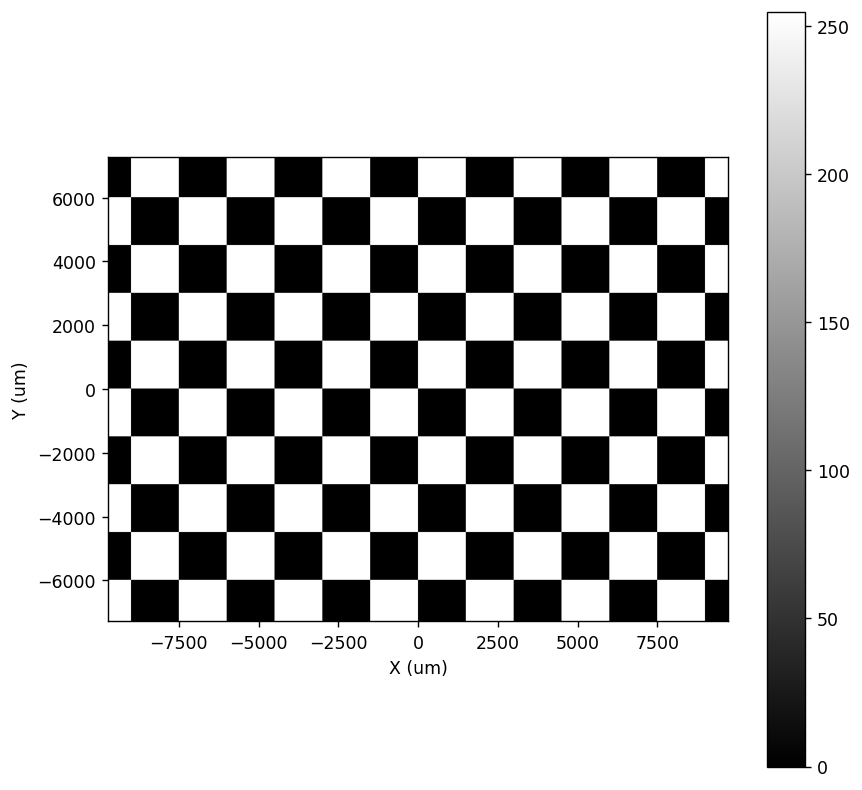

In [48]:
mascara.grating_2D_chess(r0=(0,0), period=3000, fill_factor=0.5)
slm.Send_Image(mascara, kind='intensity', draw=True)

In [62]:
slm.Close_Image('SLM')

Una vez que se ha encontrado la configuración de fase, vamos a alinear el biprisma. Para eso, se usa la imagen de dos regiones. 

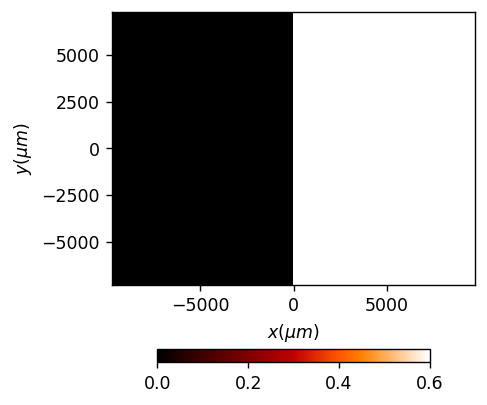

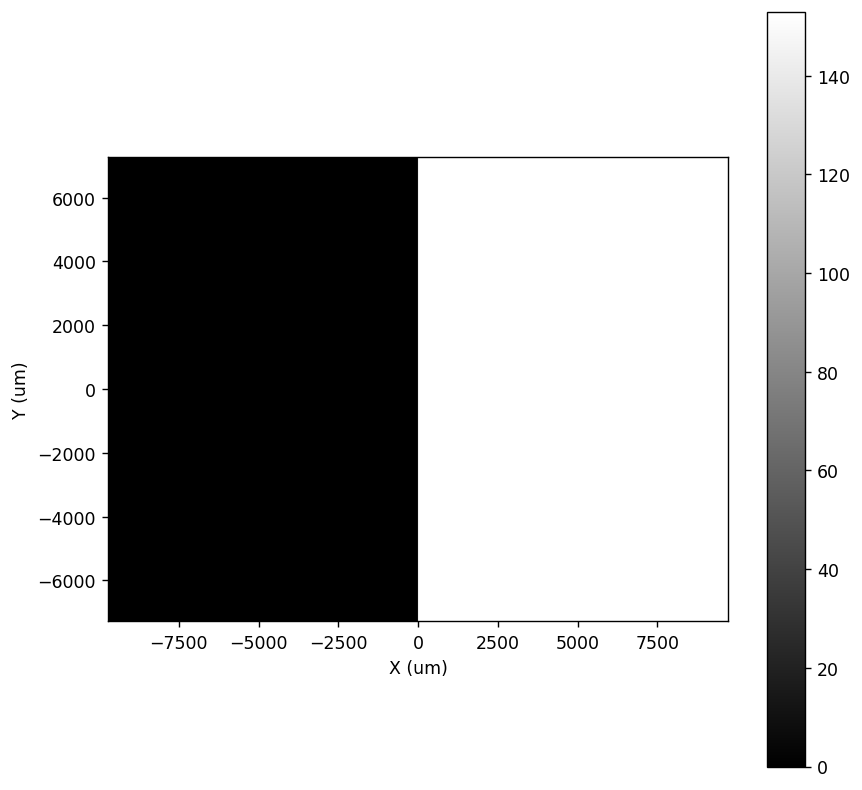

In [11]:
# Mascara con dos niveles de gris
level_min = 0
level_max = np.sqrt(0.6)
gris_doble = Scalar_mask_XY(x=slm.x, y=slm.y, wavelength=633e-9)
gris_doble.gray_scale(num_levels=2, levelMin=level_min, levelMax=level_max)
gris_doble.draw(kind='intensity', has_colorbar='horizontal');

# Mandar la imagen
slm.Send_Image(gris_doble, kind='intensity', norm=1, draw=True)

Una vez que el biprisma está centrado, vamos a alejar la camara lo maximo posible y a colocar el telescopio frente a la camara. 

In [ ]:
motor.Move_Absolute(pos=-120, units='mm')

#### Medida de la fase global

Una vez que se ha alineado el biprisma, se puede proceder a realizar la medida de las franjas para los 255 niveles de gris del sistema. Pero primero vamos a tomar la imagen de referencia de manera manual para comprobar que la imagen no se satura y tiene la máxima resolución.

The value of the property Resolution is Y800 (2592x1944).


9 229 (1944, 2592)


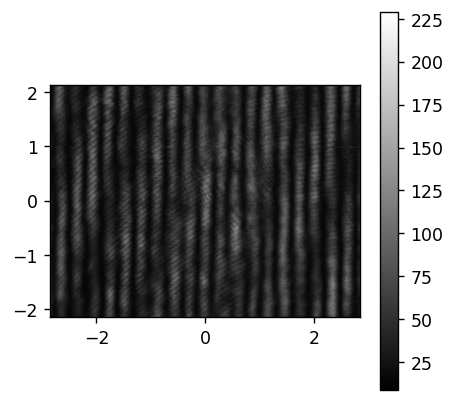

In [18]:
cam.Open()
cam.Start_Live(view=False)
cam.Get_Property(name='Resolution')
cam.Set_Property(name='Gain', value=0, is_switcher=True)
cam.Set_Property(name='Gain', value=20, is_switcher=False)
photo = cam.Get_Image(draw=True)
print(np.min(photo), np.max(photo), photo.shape)


9 171 (1944, 2592)


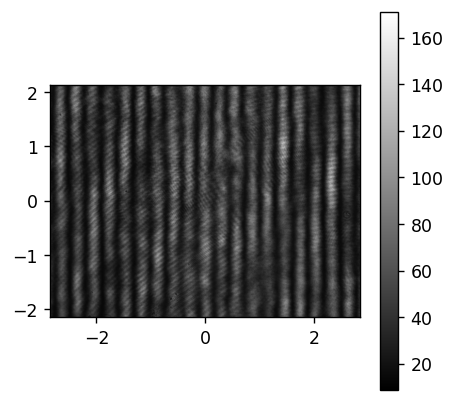

In [19]:
cam.Set_Property(name='Gain', value=10, is_switcher=False)
photo = cam.Get_Image(draw=True)
print(np.min(photo), np.max(photo), photo.shape)

Ya tenemos los parámetros adecuados para empezar a medir. A continuación, lo que tenemos que hacer es bloquear el haz (a ser posible, cerca de la cámara para que el scattering que le llega a la camara sea tenido en cuenta) y tomamos el background.

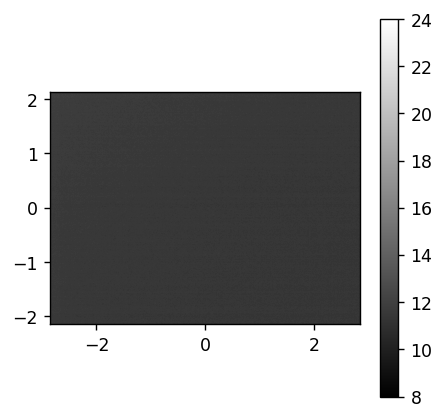

In [20]:
_ = cam.Get_Image(draw=True, is_background=True)

0 127 (1944, 2592)


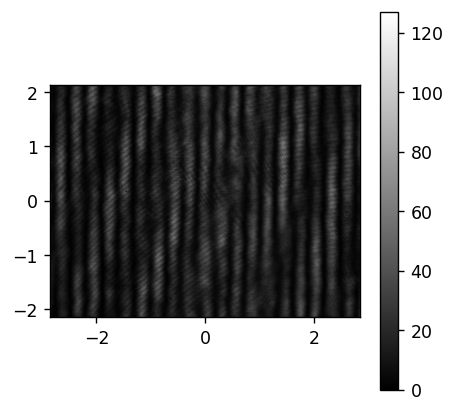

In [21]:
# Comprobacion
photo = cam.Get_Image(draw=True)
print(np.min(photo), np.max(photo), photo.shape)

Ya podemos proceder a realizar las 255 medidas:

In [22]:
Phase_Calibration_Measurement(slm, cam, levels=None, Naverage=1, wait_time=0.3)

Image 256 of 256


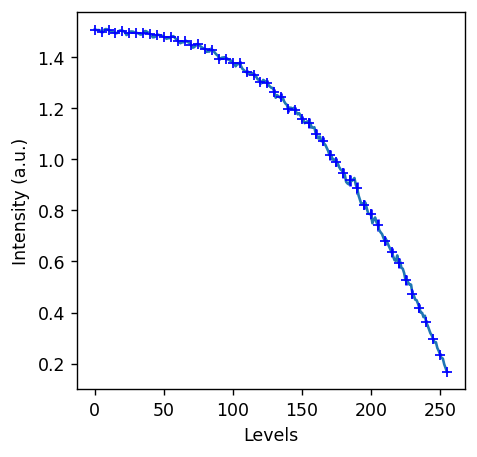

Write REPEAT to repeat the measurement, otherwise to store it. 


In [12]:
# Medir la intensidad si se desea
Intensity_Measurement(slm, daca, Naverage=32, filename='Intensidad.npz', draw=True)

In [61]:
cam.Stop_Live()

In [59]:
# Cambiar directorio si es necesario
%pwd
%cd H:\Experimentos Jesus\Fase_Fase3
%pwd

H:\Experimentos Jesus\Fase_Fase3


'H:\\Experimentos Jesus\\Fase_Fase3'